1. Using SIFT to find descriptors for every image, and stack all the descriptors
2. Using the descriptors to train a kmean for clustering
3. Creating a histogram for every image
4. Training a linear model to predict the number count of tree logs

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
class ObjectCounting():
    def __init__(self,n_cluster):
        self.n_cluster = n_cluster
        self.mega_histogram=None
        self.kmeans_model = KMeans(n_clusters = n_cluster,verbose=1,n_jobs=10)
        self.kmean_trained = None
        self.reg = LinearRegression()
        self.reg_Score = None
        self.True_Response = None
    def _get_img(self,folder):   
        img_list=[]
        img_file_list=[]
        for root,_,files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root,file)
                img_list.append(cv2.imread(file_path))
                img_file_list.append(file.split(".")[:-1])
        return img_list, len(img_list), img_file_list
#     def _img2gray(self,img):
#         return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    def _get_desc(self,img):
        sift = cv2.xfeatures2d.SIFT_create()
        keypoint, descriptor = sift.detectAndCompute(img, None)
        return keypoint, descriptor
    
    def _get_desc_list(self,img_list):
        desc_list=[]
        for img in img_list:
#             gray = self._img2gray(img)
            keypoint, descriptor = self._get_desc(img)
            desc_list.append(descriptor)
        return desc_list
    def _get_stacked_Desc(self,desc_list):
        desc_vstack = np.array(desc_list[0])
        for desc in desc_list[1:]:
            desc_vstack = np.vstack((desc_vstack, desc))
        return desc_vstack
    def _desc_clustering(self,desc_vstack):
        self.kmean_trained = self.kmeans_model.fit_predict(desc_vstack)
    def _get_desc_histogram(self,n_images,desc_list):
        self.mega_histogram = np.array([np.zeros(self.n_cluster) for i in range(n_images)])
        jobs = 0
        for img in range(n_images):
            descs = len(desc_list[img])
            for desc in range(descs):
                cluster = self.kmean_trained[jobs+desc]
                self.mega_histogram[img][cluster] += 1
            jobs += descs
    def ModelTraining(self,train,answer):
        print("Loading Training Dataset")
        train,n_images,img_file_list = self._get_img(train)
        print("Preprocessing Training Dataset")
        desc_list = self._get_desc_list(train)
        desc_vstack = self._get_stacked_Desc(desc_list)
        print("Clustering Descriptors")
        self._desc_clustering(desc_vstack)
        print("Creating Bag of Words Vocabulary")
        self._get_desc_histogram(n_images,desc_list)
        
        X = self.mega_histogram
        self.True_Response = np.zeros(n_images)
        for idx,img_file in enumerate(img_file_list):
            self.True_Response[idx] = answer.set_index('Image Name').loc[img_file,"Counts"]
        
        self.reg.fit(X, self.True_Response)
        self.reg_Score = self.reg.score(X, self.True_Response)
    def predict(self,test):
        print("Loading Test Dataset")
        test,n_images,img_file_list = self._get_img(test)
        print("Preprocessing Test Dataset")
        desc_list = self._get_desc_list(test)       
        desc_vstack = self._get_stacked_Desc(desc_list)
        print("Clustering Descriptors")
        test_clusters = self.kmeans_model.predict(desc_vstack)
        print("Mapping Bag of Words Vocabulary")
        mega_histogram = np.array([np.zeros(self.n_cluster) for i in range(n_images)])
        jobs = 0
        for img in range(n_images):
            descs = len(desc_list[img])
            for desc in range(descs):
                cluster = test_clusters[jobs+desc]
                mega_histogram[img][cluster] += 1
            jobs += descs
            
        X = mega_histogram
        predicted_y = self.reg.predict(X)  
        return (predicted_y,img_file_list)

In [8]:
CurrentDirectory = os.getcwd()
answer=pd.read_excel(os.path.join(CurrentDirectory,'TreeLogs\\Image Count.xlsx'))
train=os.path.join(CurrentDirectory,'TreeLogs\\train')
test=os.path.join(CurrentDirectory,'TreeLogs\\test')

In [9]:
ObjectCounting = ObjectCounting(n_cluster=90)
ObjectCounting.ModelTraining(train,answer)

Loading Training Dataset
Preprocessing Training Dataset
Clustering Descriptors
Creating Bag of Words Vocabulary


In [10]:
predictions = ObjectCounting.predict(test)

Loading Test Dataset
Preprocessing Test Dataset
Clustering Descriptors
Mapping Bag of Words Vocabulary


# Test Image Result
We test our visual bag of word model for evaluating performance

In [99]:
df = pd.DataFrame(ObjectCounting.mega_histogram)
df['True Response']=ObjectCounting.True_Response
for x in range(90):
    colname="Cluster"+str(x+1) + " Counts"
    df.rename(index=str, columns={x: colname},inplace=True)
test_trueY=[]
for i,prediction in zip(predictions[1],predictions[0]):
    test_trueY.append([i[0],answer.set_index("Image Name").loc[i[0],"Counts"],prediction])
#     print(prediction)

In [102]:
pd.DataFrame(test_trueY,columns=["Image Name","True Counts","Predicted Counts"])

Image Name  True Counts  Predicted Counts
0     Img101            6         -1.971050
1     Img102           16         79.872475
2     Img103           21        213.061106
3     Img104            9        146.398231

Histogram For Training Images

In [69]:
df

Cluster1 Counts  Cluster2 Counts  Cluster3 Counts  Cluster4 Counts  \
0              13.0             10.0              9.0              7.0   
1             121.0            112.0            232.0            123.0   
2             259.0            179.0            214.0            246.0   
3              58.0            103.0             44.0             62.0   
4              13.0             10.0             14.0              8.0   
5               6.0              4.0             36.0             23.0   
6              13.0             16.0             27.0              3.0   
7              20.0             41.0             10.0             13.0   
8               4.0              3.0              9.0              2.0   
9              95.0            140.0            130.0            105.0   
10              4.0             10.0             19.0             13.0   
11             23.0             14.0             29.0             62.0   
12             50.0             27.0             85.0             61.0   
13             33.0             49.0             54.0             41.0   
14             27.0             41.0             63.0             29.0   
15             92.0             43.0             30.0             47.0   
16             31.0             30.0             16.0             21.0   
17              2.0              6.0              9.0              8.0   
18             58.0             26.0             53.0             58.0   
19              9.0              3.0             65.0             31.0   
20             11.0             21.0             17.0             11.0   
21             27.0             16.0             50.0             24.0   
22              1.0              7.0              2.0              2.0   
23             91.0             60.0            113.0             85.0   
24             11.0              5.0              5.0              2.0   
25            223.0            313.0            261.0            379.0   
26             26.0             24.0             46.0             29.0   
27             28.0             22.0             18.0              8.0   
28             94.0            104.0             69.0             87.0   
29             31.0             18.0             28.0             12.0   
..              ...              ...              ...              ...   
70             85.0             62.0            103.0             90.0   
71             23.0             41.0             22.0             24.0   
72             11.0             63.0              7.0             13.0   
73              8.0              5.0              4.0              6.0   
74             24.0             21.0             21.0             29.0   
75             24.0             22.0             28.0             16.0   
76             14.0              6.0             19.0             15.0   
77              9.0              1.0              5.0              3.0   
78              3.0              1.0             10.0              3.0   
79             17.0              5.0             15.0             13.0   
80             55.0            156.0             47.0             51.0   
81             10.0              2.0             19.0              3.0   
82             58.0             16.0             81.0             50.0   
83            166.0             72.0             27.0             74.0   
84             26.0             18.0             29.0             31.0   
85             25.0             22.0             26.0             15.0   
86            113.0            157.0             76.0             88.0   
87              9.0              2.0             19.0              8.0   
88            102.0            124.0            155.0            113.0   
89             86.0            143.0            112.0            100.0   
90             69.0             63.0             48.0             50.0   
91             64.0             15.0             45.0             80.0   
92      

Linear Regression Analysis Plot

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

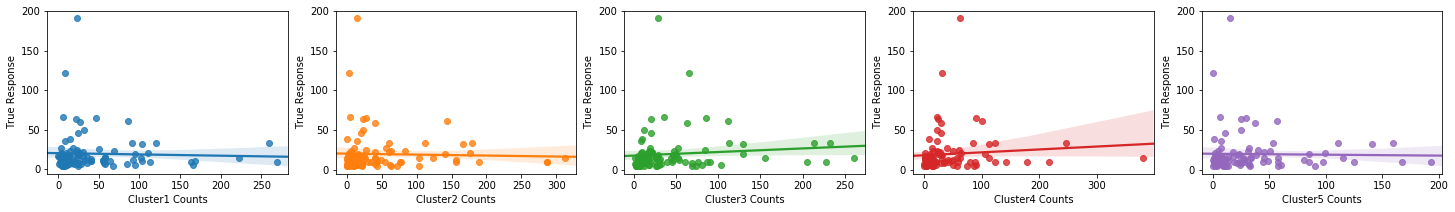

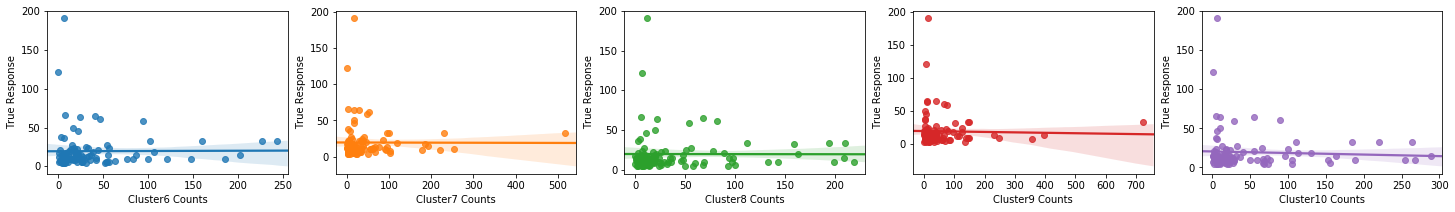

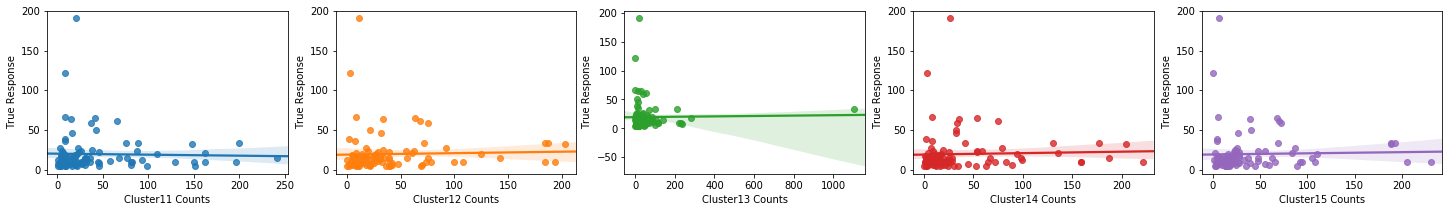

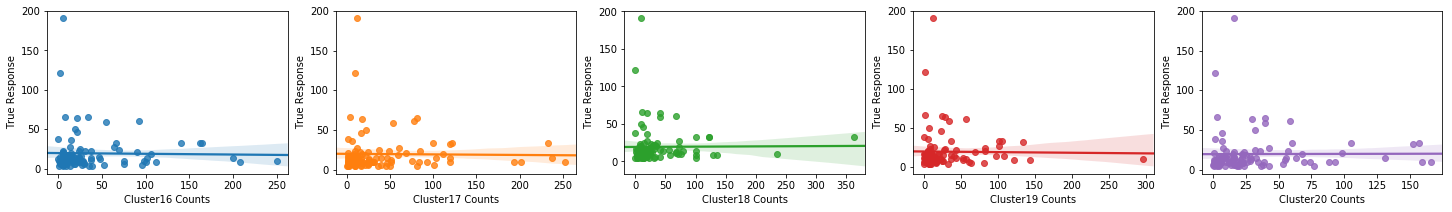

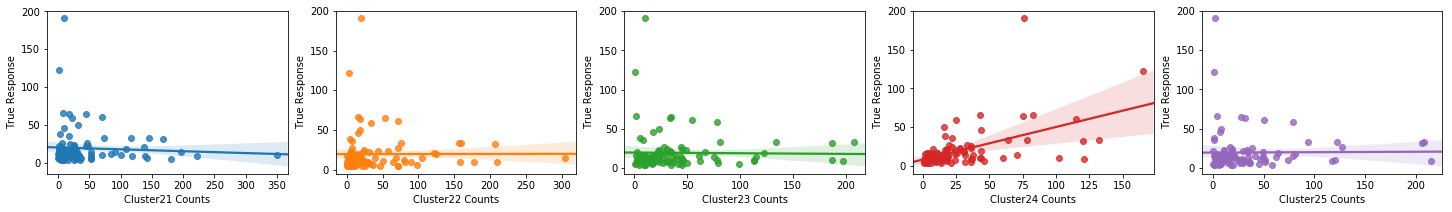

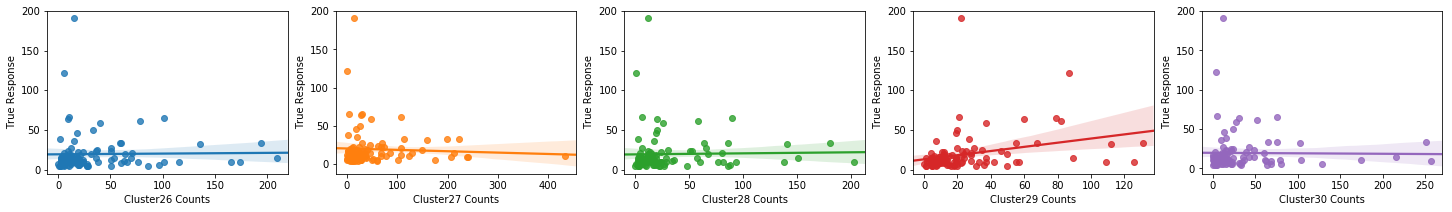

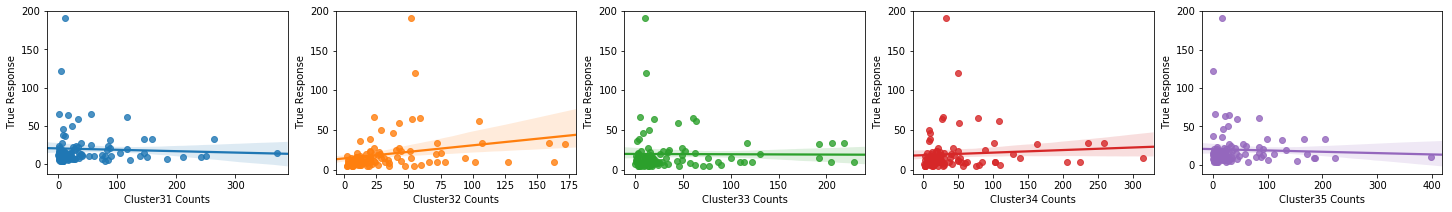

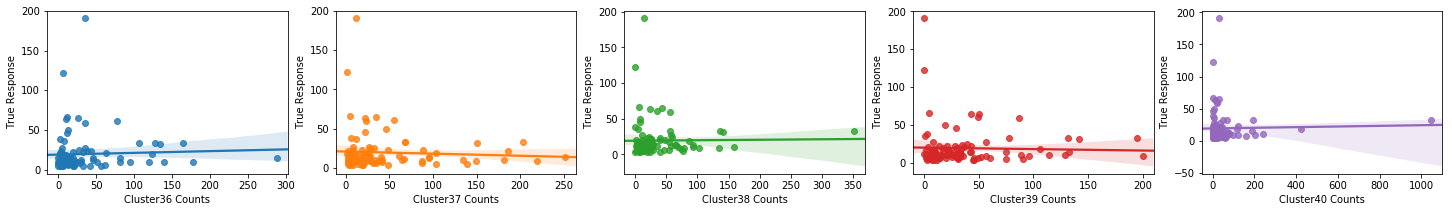

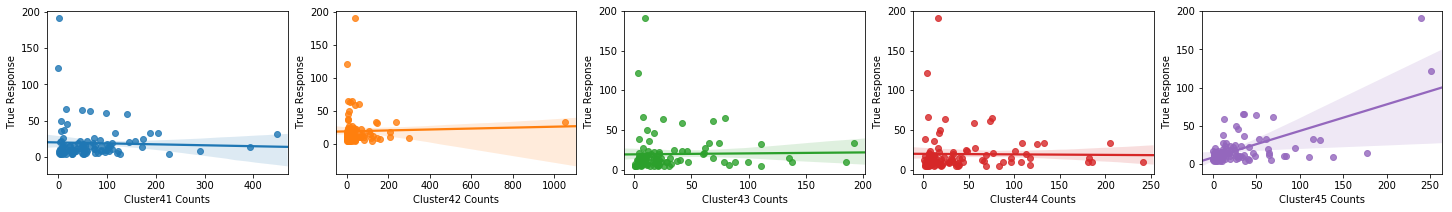

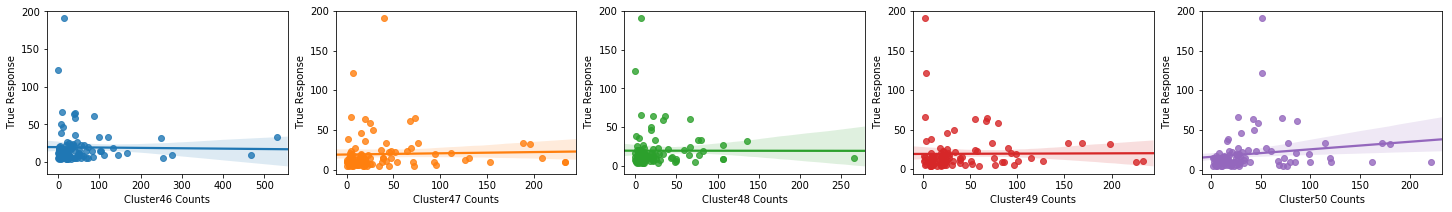

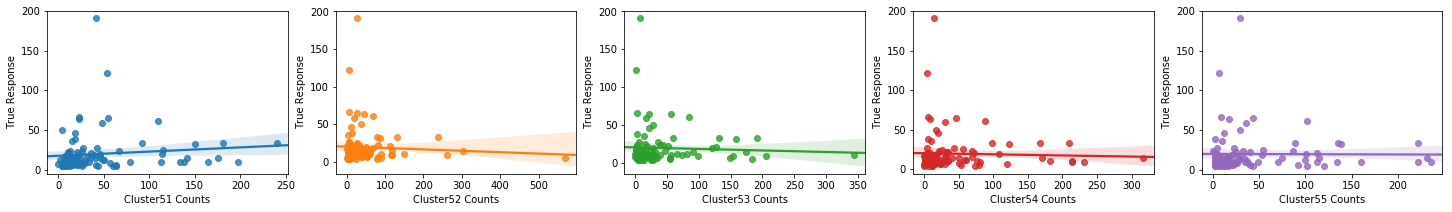

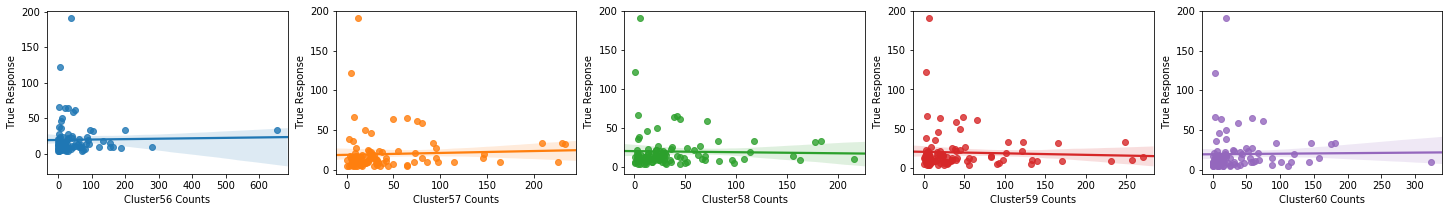

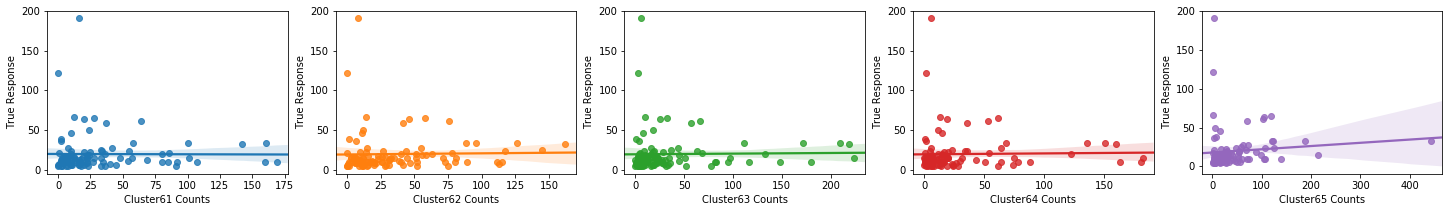

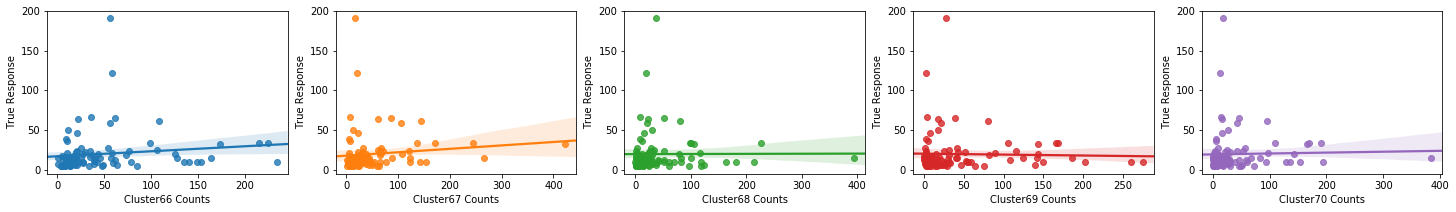

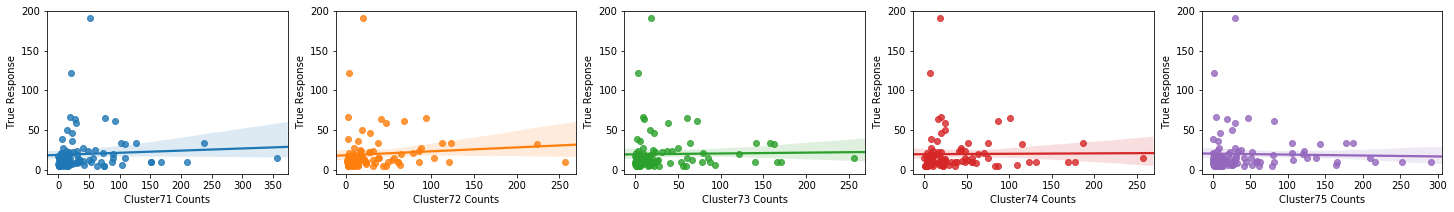

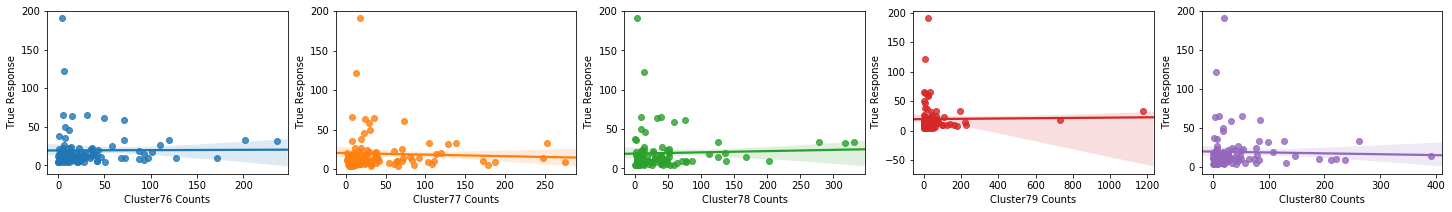

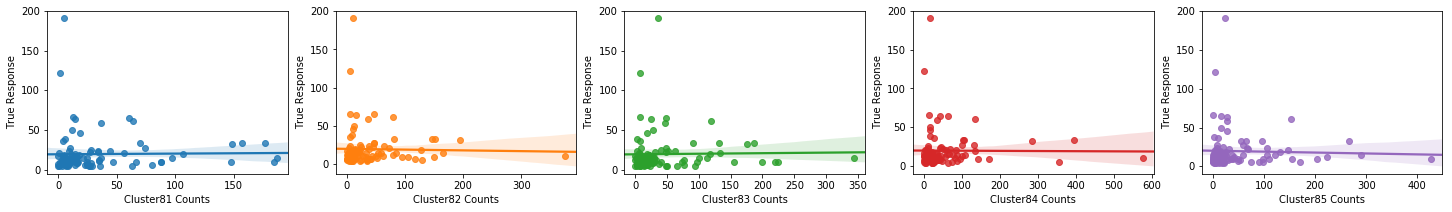

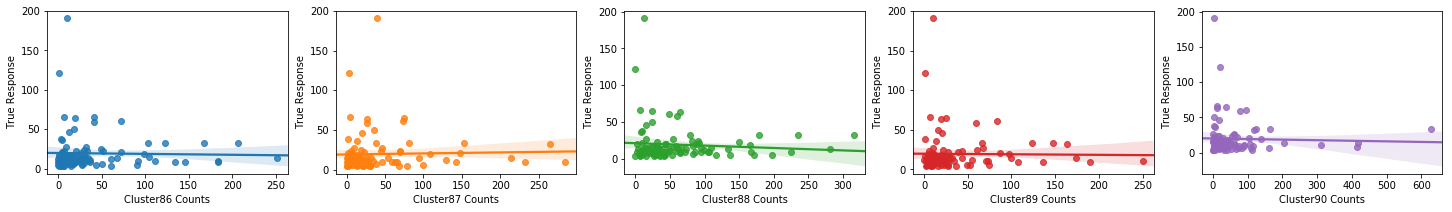

In [72]:

ncols=5
c = ObjectCounting.n_cluster/ncols
ix = 0

while c > 0 :
    c-=1
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=ncols,sharex=False,sharey=False,figsize=(25,3))
    sns.regplot(x=df["Cluster"+str(ix+1) + " Counts"], y=df['True Response'],ax=ax1)
    sns.regplot(x=df["Cluster"+str(ix+2) + " Counts"], y=df['True Response'],ax=ax2)
    sns.regplot(x=df["Cluster"+str(ix+3) + " Counts"], y=df['True Response'],ax=ax3)
    sns.regplot(x=df["Cluster"+str(ix+4) + " Counts"], y=df['True Response'],ax=ax4)
    sns.regplot(x=df["Cluster"+str(ix+5) + " Counts"], y=df['True Response'],ax=ax5)
    ix+=ncols
plt.savefig("Regression Analysis.jpg")